In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240831%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240831T042958Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4ed69f8c028323ce183d587ecedb9185a1f08009b4d6891ce3e483f85a7138f5b42bad595be12c27e50fa52be92bde4ea81c8a8181096fd59cc2ddd2ca738020c0cafe1539438bbed19bd7ae1c927691948dba6ca0a350dd07eacd5a8ac1cc12e7a6d5e9965bebd6aa8040cfc5a640e5cd597bc88c872cc474f221f72b6490d4dbd3005fd5dacd6daa8dce265eac7eee7db433e5445775eecac7bc45b09a491fc8de94549331e5067fcbfd5bfca2b240c95b48bb69f75bab67d5ce797b89c90b01bc9251a7ea1aca771327eaba37d3a275dbf811eb672b5a86813c7561e4c8e03cce84280e13c19e42faed144f6b939e4cf8407b24662a77a78e8cf3f67361fa'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
! ls ../input/digit-recognizer

sample_submission.csv  test.csv  train.csv


In [ ]:
# import train and test dataset
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

In [ ]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#check for missing values:
print(train.isnull().sum())
print(test.isnull().sum())
#no null values- ezz

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64
pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64


**EDA**

<ipython-input-135-3abb30e0a942>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train.label,palette='Dark2')


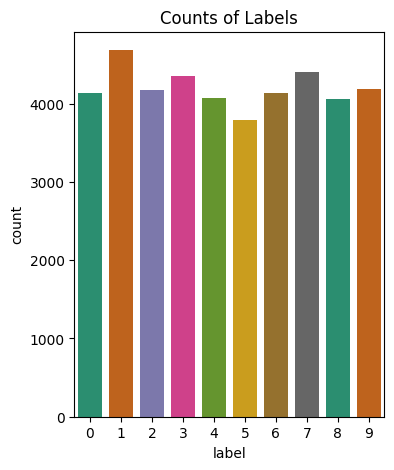

In [ ]:
#plot the labels:
plt.figure(figsize=(4,5))
sns.countplot(x=train.label,palette='Dark2')
plt.title("Counts of Labels")
plt.show()
#data looks balanced- gg

<ipython-input-136-1a8796f218a7>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 4, ind+1)
<ipython-input-136-1a8796f218a7>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title(row[0])


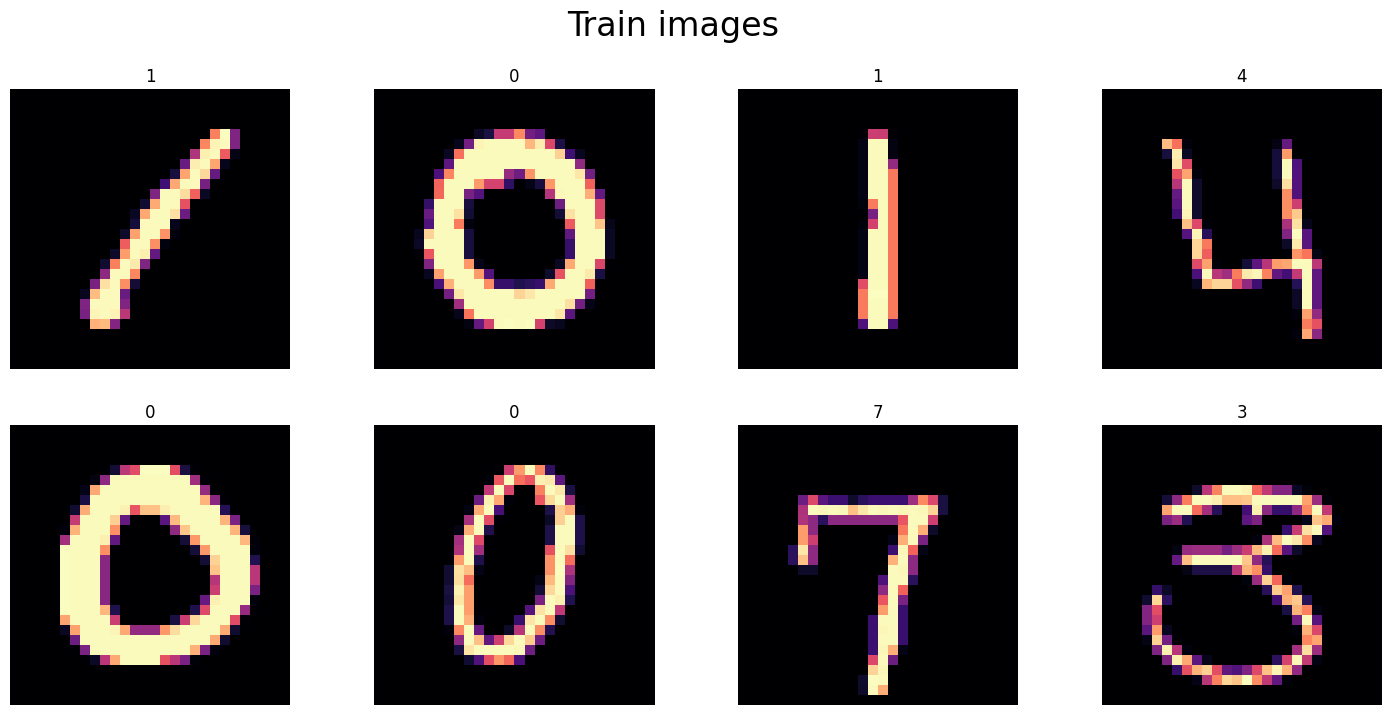

In [ ]:
# first few train images with labels
fig, ax = plt.subplots(figsize=(18, 8))
for ind, row in train.iloc[:8, :].iterrows():
    plt.subplot(2, 4, ind+1)
    plt.title(row[0])
    img = row.to_numpy()[1:].reshape(28, 28)
    fig.suptitle('Train images', fontsize=24)
    plt.axis('off')
    plt.imshow(img, cmap='magma')

<ipython-input-137-361d746d14e1>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 4, ind+1)


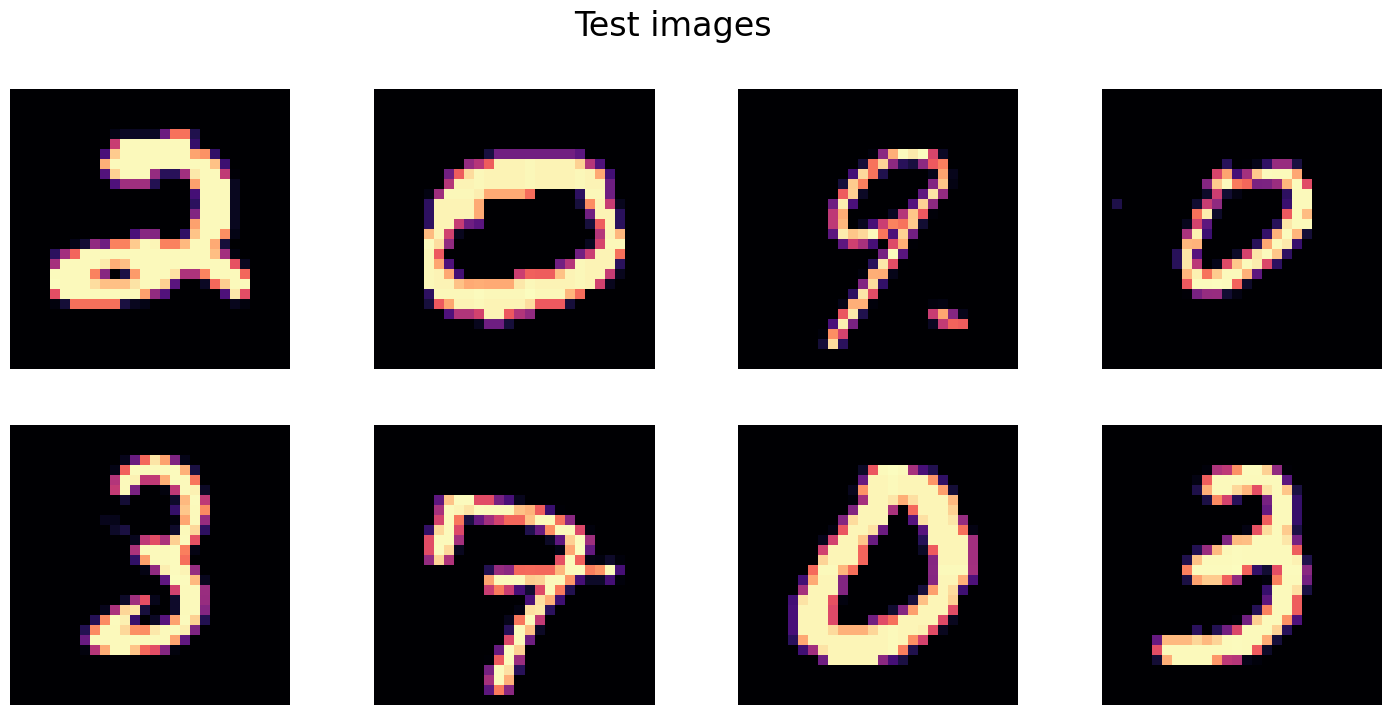

In [ ]:
# first few test images
fig, ax = plt.subplots(figsize=(18, 8))
for ind, row in test.iloc[:8, :].iterrows():
    plt.subplot(2, 4, ind+1)
    img = row.to_numpy()[:].reshape(28, 28)
    fig.suptitle('Test images', fontsize=24)
    plt.axis('off')
    plt.imshow(img, cmap='magma')

In [ ]:
#test data k labels ni hain- we need to predict them:
X=train.iloc[:,1:].to_numpy()
y=train['label'].to_numpy()
test=test.to_numpy()
# numpy m isiliye convert krna h taaki ezz reshape krpaao end m

In [ ]:
y

array([1, 0, 1, ..., 7, 6, 9])

In [ ]:
X=X/255.0
test=test/255.0
# reshape the dataframe to 3x3 matrix with 1 channel grey scale values
X = X.reshape(-1,28,28,1)
test = test.reshape(-1,28,28,1)

print(X.shape)
print(test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


In [ ]:
y_encoded=pd.get_dummies(data=y)

In [ ]:
y_encoded.shape


(42000, 10)

In [ ]:
#train and vlidation split:
X_train,X_test, y_train, y_test=train_test_split(X,y_encoded,random_state=42,test_size=0.3)

In [ ]:
y_train=y_train.to_numpy()

In [ ]:
for i in [X_train, y_train, X_test, y_test]:
    print(i.shape)

(29400, 28, 28, 1)
(29400, 10)
(12600, 28, 28, 1)
(12600, 10)


[False False False False  True False False False False False]


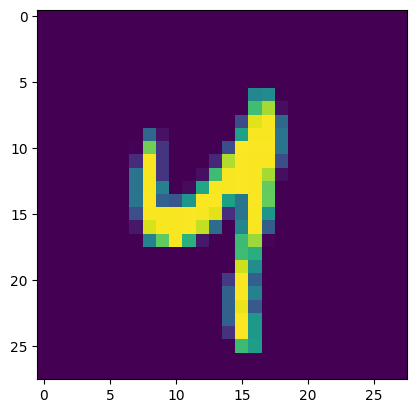

In [ ]:
# image processing
import matplotlib.image as mpimg

g = plt.imshow(X_train[0][:,:,0])
#yahape we need the first image and uska all rows, all columns and first and only channel 0-because mnist dataset is greyscale images
print(y_train[0])


In [ ]:
INPUT_SHAPE = (28,28,1)
OUTPUT_SHAPE = 10
BATCH_SIZE = 128
EPOCHS = 10
VERBOSE = 2

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout



In [ ]:
Classifier=Sequential()


In [ ]:
Classifier.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=INPUT_SHAPE))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
Classifier.add(MaxPool2D(pool_size=(2,2),padding='same'))

In [ ]:
Classifier.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
Classifier.add(MaxPool2D((2,2)))

In [ ]:
Classifier.add(Flatten())

In [ ]:
Classifier.add(Dense(128,activation='relu'))
Classifier.add(Dropout(0.2))

In [ ]:
Classifier.add(Dense(64,activation='relu'))
Classifier.add(Dropout(0.2))

In [ ]:
Classifier.add(Dense(10,activation='softmax'))

In [ ]:
Classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
Classifier.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 232,650 (908.79 KB)

 Trainable params: 232,650 (908.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = Classifier.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=VERBOSE,
                    validation_split=0.3)

Epoch 1/10
161/161 - 7s - 41ms/step - accuracy: 0.8169 - loss: 0.5647 - val_accuracy: 0.9620 - val_loss: 0.1323
Epoch 2/10
161/161 - 1s - 5ms/step - accuracy: 0.9553 - loss: 0.1481 - val_accuracy: 0.9761 - val_loss: 0.0783
Epoch 3/10
161/161 - 1s - 6ms/step - accuracy: 0.9693 - loss: 0.1029 - val_accuracy: 0.9788 - val_loss: 0.0674
Epoch 4/10
161/161 - 1s - 6ms/step - accuracy: 0.9747 - loss: 0.0815 - val_accuracy: 0.9832 - val_loss: 0.0613
Epoch 5/10
161/161 - 1s - 6ms/step - accuracy: 0.9805 - loss: 0.0654 - val_accuracy: 0.9797 - val_loss: 0.0704
Epoch 6/10
161/161 - 1s - 4ms/step - accuracy: 0.9841 - loss: 0.0521 - val_accuracy: 0.9840 - val_loss: 0.0561
Epoch 7/10
161/161 - 1s - 8ms/step - accuracy: 0.9841 - loss: 0.0466 - val_accuracy: 0.9870 - val_loss: 0.0497
Epoch 8/10
161/161 - 1s - 8ms/step - accuracy: 0.9883 - loss: 0.0384 - val_accuracy: 0.9855 - val_loss: 0.0558
Epoch 9/10
161/161 - 1s - 4ms/step - accuracy: 0.9896 - loss: 0.0313 - val_accuracy: 0.9863 - val_loss: 0.0490


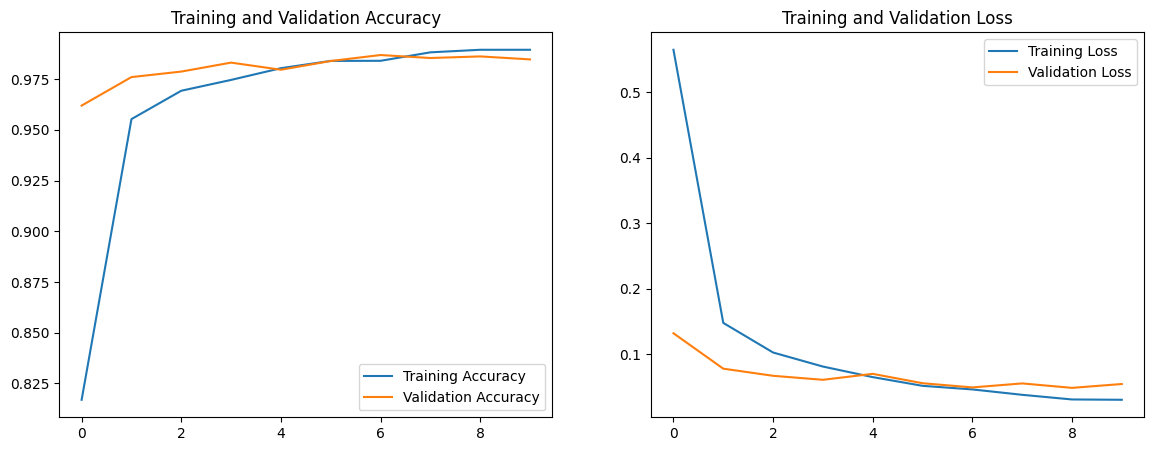

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig('./foo.png')
plt.show()

In [ ]:
Classifier.evaluate(X_test, y_test_numeric, verbose=False)

[0.04681874066591263, 0.9863492250442505]

In [ ]:
y_pred=Classifier.predict(X_test)
y_predicted = np.argmax(y_pred, axis=1)
y_actual=np.argmax(y_test_numeric,axis=1)

394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
y_test_numeric = y_test.astype(int)
y_test_numeric
#yahi step ki vjh se bt aarhi thi


array([[0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [ ]:
print(classification_report(y_actual,y_predicted))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1200
           1       0.99      1.00      0.99      1389
           2       0.99      0.98      0.99      1294
           3       0.99      0.98      0.99      1355
           4       0.98      0.98      0.98      1222
           5       0.97      0.99      0.98      1085
           6       0.99      0.99      0.99      1256
           7       0.98      0.99      0.99      1359
           8       0.99      0.97      0.98      1209
           9       0.99      0.98      0.98      1231

    accuracy                           0.99     12600
   macro avg       0.99      0.99      0.99     12600
weighted avg       0.99      0.99      0.99     12600

